In [183]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import re
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F 
from tqdm import tqdm
import plotly.express as px
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [184]:
!pip install deep-translator
from deep_translator import GoogleTranslator

In [185]:
# вот он я
%ls /kaggle/input/youtube-videos-dataset/

youtube.csv


In [186]:
df = pd.read_csv("/kaggle/input/youtube-videos-dataset/youtube.csv")
df

,link,title,description,category
0,JLZlCZ0,Ep 1| Travelling through North East India | Of...,Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nT...,travel
1,i9E_Blai8vk,Welcome to Bali | Travel Vlog | Priscilla Lee,Priscilla Lee\n45.6K subscribers\nSUBSCRIBE\n*...,travel
2,r284c-q8oY,My Solo Trip to ALASKA | Cruising From Vancouv...,Allison Anderson\n588K subscribers\nSUBSCRIBE\...,travel
3,Qmi-Xwq-ME,Traveling to the Happiest Country in the World!!,Yes Theory\n6.65M subscribers\nSUBSCRIBE\n*BLA...,travel
4,_lcOX55Ef70,Solo in Paro Bhutan | Tiger's Nest visit | Bhu...,Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nH...,travel
...,...,...,...,...
3594,#NAME?,21st Century Challenges: Crash Course European...,CrashCourse\n12.4M subscribers\nSUBSCRIBE\nThe...,history
3595,d-2Trw8bCa0,EU DataViz webinar - Barnaby Skinner - How to ...,Publications Office of the European Union\n3.2...,history
3596,RCKWarkUL,Stone Age Scandinavia: First People In the Nor...,History Time\n619K subscribers\nSUBSCRIBE\n- W...,history
3597,MF6F3BxJIY,AP European History - Interwar Period: Paris P...,Mr. Raymond's Civics and Social Studies Academ...,history


In [187]:
# по условию задачи нас интересует только заголовок
# Удалим информацию о описании а также посмотрим несколько заголовков
# Также проверим на nan столбцы описания и категории
df = df.drop('description', axis=1)
df

,link,title,category
0,JLZlCZ0,Ep 1| Travelling through North East India | Of...,travel
1,i9E_Blai8vk,Welcome to Bali | Travel Vlog | Priscilla Lee,travel
2,r284c-q8oY,My Solo Trip to ALASKA | Cruising From Vancouv...,travel
3,Qmi-Xwq-ME,Traveling to the Happiest Country in the World!!,travel
4,_lcOX55Ef70,Solo in Paro Bhutan | Tiger's Nest visit | Bhu...,travel
...,...,...,...
3594,#NAME?,21st Century Challenges: Crash Course European...,history
3595,d-2Trw8bCa0,EU DataViz webinar - Barnaby Skinner - How to ...,history
3596,RCKWarkUL,Stone Age Scandinavia: First People In the Nor...,history
3597,MF6F3BxJIY,AP European History - Interwar Period: Paris P...,history


In [188]:
print(df['title'][0])
print(df['title'][10])
print(df['title'][100])
print(df['title'][1000])

Ep 1| Travelling through North East India | Off To Arunachal | The Journey Begins | Pasighat
How to become a Travel Blogger | How to Start a Travelling YouTube channel
How To Make a TRAVEL VIDEO - 10 Tips you need to know
Thoughts Desi People Have in America | MostlySane


In [189]:
# проверим на nan
df[df.isnull().any(1)]

,link,title,category


Как видно в заголовках присутствуют специальные символы/номер серии и тд. Следует от них избавиться. Для этого сделаем регулярные выражение. Кроме того начнем преобразование данных в виде нужному bert а именно начнем разделять предложения с помощью [sep]. Также проблемой является то что bert способен обрабатывать максимум по 2 предложения. Для решения этой проблемы проверим насколько часто встречаются символы | 1 раз и более.

In [190]:
count_0 = 0
count_1 = 0
count_2 = 0
max_words = 0
for ind in df.index:
    title = df.title[ind]
    kol = len(title.split())
    counter = title.count('|')
    if counter == 0:
        count_0 = count_0 + 1
    elif counter == 1:
        count_1 = count_1 + 1
    else:
        count_2 = count_2 + 1
    if kol>max_words:
        max_words = kol

In [191]:
print(count_0, count_1, count_2, max_words)

2028 592 979 24


Как видно присутствует множество описаний из нескольких предложений. Есть 3 варианта их обработки. Первым вариантом является взять 2 наибольших предложений из доступных из данного заголовка. Другой вариант это разбитие одного заголовка на множество что лучше с точки зрения обучения но может создать множество малоимформативных примеров. Также мы можем просто игнорировать такой разбитие и использовать заголовок как 1 предложение. Для начала попробуем такой вариант а там посмотрим. 


In [192]:
cats = df.groupby('category').size().reset_index().rename(columns={0: 'total'}).sort_values('total', ascending=False)
fig = px.pie(cats, values='total', names='category', color_discrete_sequence=px.colors.sequential.PuBuGn , title="Categories in the dataset proportion")
fig.show()

In [193]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


In [194]:
labels = {'travel':0,
          'art_music':1,
          'food':2,
          'history':3
          }

In [195]:

example_text = [['How to become a Travel Blogger' , 'How to Start a Travelling YouTube channel']]
bert_input = tokenizer(example_text,padding='max_length', max_length = 40, 
                       truncation=True, return_tensors="pt")

In [196]:
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,  1731,  1106,  1561,   170,  7938,   139, 13791,  2895,   102,
          1731,  1106, 15599,   170,  7938,  1979,  7673,  3094,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [197]:
example_text = tokenizer.decode(bert_input.input_ids[0])
print(example_text)

[CLS] How to become a Travel Blogger [SEP] How to Start a Travelling YouTube channel [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [198]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [199]:
# начнем удаление лишних символов и слов , |??*|,|:|-\s
# возможно стоит привести все к 1 регистру
# посмотрел 500 первых заголовков. Основная проблема смайлы и арабских (или че это хз)
df_new = df.copy()
delet_list = ['ep\w*\d* ', 'episode\w*\d* ', 'series \d*\| ', '\d\d*\w* ', '!!*', '\?\?*', 
              '🇵🇹', '🌞', '🚲', '🛥️', '⚓', '@', '☀','-\s', '#','🍣', '\+','\*', '😍','$','😋', '🇹🇭', '🌍', '✨', '&', '\d\d*', '\(\w*\)',
             '\[', '\]', '📸', '😉','😉','😁','😁', '💛', 
             '🤣' ,'🤪', '😂', '💉', ':-\)', '☺️', '❤', '✔️', '🐺', '•', '\( \w* \)', '\([^)]*\)', '%']
probel_list = ['/', '//*', '[^A-Za-z0-9]+']
for ind in df_new.index:
    new_str = df_new.title[ind]
    new_str = new_str.lower()
    for st in delet_list:
        #print(st)
        new_str = re.sub(st, '', new_str)
        #print(new_str)
    for st in probel_list:
        new_str = re.sub(st, ' ', new_str)
    # АХТУНГ. тут творится грязь. Потом надо будет мб поменять
    new_str = re.sub('\| ', '', new_str)
    new_str = re.sub(' \|', '', new_str)
    df_new.at[ind, 'title'] = new_str
df_new

,link,title,category
0,JLZlCZ0,travelling through north east india off to ar...,travel
1,i9E_Blai8vk,welcome to bali travel vlog priscilla lee,travel
2,r284c-q8oY,my solo trip to alaska cruising from vancouver...,travel
3,Qmi-Xwq-ME,traveling to the happiest country in the world,travel
4,_lcOX55Ef70,solo in paro bhutan tiger s nest visit bhutan ...,travel
...,...,...,...
3594,#NAME?,century challenges crash course european history,history
3595,d-2Trw8bCa0,eu dataviz webinar barnaby skinner how to make...,history
3596,RCKWarkUL,stone age scandinavia first people in the north,history
3597,MF6F3BxJIY,ap european history interwar period paris peac...,history


In [200]:
# альтернативный способ в котором берем одно наибольшее предложение (чтобы было меньше всякой чепухи и больше связанности)
def clean_str(old_str):
    #new_str = old_str.lower()
    str_len = 0
    new_str = ''
    for i in old_str.split('|'):
        if len(i.split()) > str_len:
            new_str = i
            str_len = len(i.split())
    new_str = ' '.join(new_str.split())
    for st in delet_list:
        new_str = re.sub(st, '', new_str)
    for st in probel_list:
        new_str = re.sub(st, ' ', new_str)
    new_str = remove_emojis(new_str)
    return new_str

In [201]:
df_new = df.copy()
for ind in df_new.index:
    new_str = df_new.title[ind]
    new_str = clean_str(new_str)
    new_str = GoogleTranslator(source='auto', target='en').translate(new_str)
    if len(new_str)<5:
        df_new = df_new.drop(index=[ind])
    else:
        df_new.at[ind, 'title'] = new_str
    if ind % 100 == 0:
        print(ind)
df_new

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


,link,title,category
0,JLZlCZ0,Travelling through North East India,travel
1,i9E_Blai8vk,Welcome to Bali,travel
2,r284c-q8oY,My Solo Trip to ALASKA,travel
3,Qmi-Xwq-ME,Traveling to the Happiest Country in the World,travel
4,_lcOX55Ef70,Only in Paro Bhutan,travel
...,...,...,...
3594,#NAME?,Century Challenges Crash Course European History,history
3595,d-2Trw8bCa0,EU DataViz webinar Barnaby Skinner How to make...,history
3596,RCKWarkUL,Stone Age Scandinavia First People In the North,history
3597,MF6F3BxJIY,AP European History Interwar Period Paris Peac...,history


In [202]:
st = 'VLOG #3 | Vacation Started | Exploring Andaman | Travel Blogs | Andaman Tour | Moupriya Dutta'
new_str = re.sub('[^A-Za-z0-9]+', ' ', st)
new_str

'VLOG 3 Vacation Started Exploring Andaman Travel Blogs Andaman Tour Moupriya Dutta'

In [203]:
st = 'हिंदी full history of india PAPA VIDEO compilation one liner upsc uppsc ias psc ssc upsi upsssc ctet'
GoogleTranslator(source='auto', target='en').translate(st)

'हिंदी full history of india PAPA VIDEO compilation one liner upsc uppsc ias psc ssc upsi upsssc ctet'

In [204]:
df_new.to_excel('new_data.xlsx')

In [205]:
#!tar -zcvf new_data.tar /kaggle/working/new_data.xlsx
!zip archivename.zip /kaggle/working/new_data.xlsx
from IPython.display import FileLink
FileLink(r'archivename.zip')

updating: kaggle/working/new_data.xlsx (deflated 1%)


/kaggle/working/archivename.zip

In [206]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 50, truncation=True,
                                return_tensors="pt", return_token_type_ids = True) for text in df['title']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [207]:
# добавляет последний слой 
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids = input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        #final_layer = self.relu(linear_output)
        #final_layer = self.softmax(linear_output)
        return linear_output

In [208]:
np.random.seed(112)
train_size = 0.8
df_train = df_new.sample(frac=train_size,random_state=200)
df_val = df_new.drop(df_train.index).reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

print(len(df_train),len(df_val))

2843 711


In [209]:
df_val

,link,title,category
0,#NAME?,EP Uttarkashi to Gangotri Dham,travel
1,OyT_VzEGH,SINGAPORE VLOG Indian Girl Traveling Solo in S...,travel
2,qZwQtw7Ccz0,Stto Becoming a Travel Blogger Tips by Swathi ...,travel
3,Elb-qlUPY6g,Spiti Valley Road Trip From Shimla to Kaza,travel
4,AhenKUiVslA,WHY TRAVEL BLOGGERS ARE NOT HONEST,travel
...,...,...,...
706,fhxfEGWbe00,The AP European History Cup Song,history
707,Ch4dLCG1p2Y,The Minoans The First Great European Civilizat...,history
708,YhItwceFp4,The Versailles Peace Conference AP European Hi...,history
709,5vQo3-Wn2V,Absolutism and Constitutionalism,history


In [210]:
 datasets = {'train': Dataset(df_train), 'val': Dataset(df_val)}

In [211]:
dataloader = {'train' : torch.utils.data.DataLoader(datasets['train'], batch_size=16, shuffle=True),
                'val' : torch.utils.data.DataLoader(datasets['val'], batch_size=16)}

In [212]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [213]:

model = BertClassifier().to(device)
for name, param in model.named_parameters():
    param.requires_grad = True 
criterion = nn.CrossEntropyLoss().to(device)

optimizer = Adam(model.parameters(), lr = 1e-6)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [214]:

def train_model(model, criterion, optimizer, num_epochs=3):
    all_true_labels = []
    all_preds = []
    inputs_str = []
    loss_list = {'train' : [], 'val':[]}
    acc_list = {'train' : [], 'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                print('start train')
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_true_labels = []
            all_preds = []
            inputs_str = []
            for inputs, labels in tqdm(dataloader[phase]):
                mask = inputs['attention_mask'].to(device)
                input_id = inputs['input_ids'].squeeze(1).to(device)
                token_type_ids = inputs['token_type_ids'].to(device)
                labels = labels.to(device)
                #print(len(input_id), len(mask), len(token_type_ids))
                outputs = model(input_id, mask)
                    
                loss = criterion(outputs, labels)
                #loss = loss1
                #print(loss1)
                #print(loss2)
                #if loss.isnan():
                #    loss = eps
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    #torch.nn.utils.clip_grad_norm_(model.parameters(), 20)
                    #model.float()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() #* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())
                inputs_str.extend(input_id.tolist())
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            
            #epoch_f_score = f1(torch.tensor(all_true_labels), torch.tensor(all_preds))

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc
                                                        ))
            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc.tolist())
    return all_true_labels, all_preds, inputs_str, loss_list, acc_list
            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [215]:
epox_num = 30
all_true_labels, all_preds, inputs_str, loss, acc = train_model(model, criterion, optimizer, epox_num)

Epoch 1/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.18it/s]


train loss: 0.0838, acc: 0.3458


100%|██████████| 45/45 [00:02<00:00, 20.91it/s]


val loss: 0.0765, acc: 0.5218
Epoch 2/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0704, acc: 0.5677


100%|██████████| 45/45 [00:02<00:00, 21.51it/s]


val loss: 0.0636, acc: 0.6807
Epoch 3/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.29it/s]


train loss: 0.0585, acc: 0.7081


100%|██████████| 45/45 [00:02<00:00, 20.78it/s]


val loss: 0.0518, acc: 0.7890
Epoch 4/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.26it/s]


train loss: 0.0476, acc: 0.7999


100%|██████████| 45/45 [00:02<00:00, 21.23it/s]


val loss: 0.0418, acc: 0.8354
Epoch 5/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.26it/s]


train loss: 0.0388, acc: 0.8382


100%|██████████| 45/45 [00:02<00:00, 21.34it/s]


val loss: 0.0351, acc: 0.8664
Epoch 6/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0329, acc: 0.8692


100%|██████████| 45/45 [00:02<00:00, 21.38it/s]


val loss: 0.0303, acc: 0.8833
Epoch 7/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0277, acc: 0.8906


100%|██████████| 45/45 [00:02<00:00, 21.33it/s]


val loss: 0.0264, acc: 0.8973
Epoch 8/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0235, acc: 0.9114


100%|██████████| 45/45 [00:02<00:00, 21.46it/s]


val loss: 0.0235, acc: 0.8987
Epoch 9/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0204, acc: 0.9240


100%|██████████| 45/45 [00:02<00:00, 21.41it/s]


val loss: 0.0213, acc: 0.9044
Epoch 10/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0173, acc: 0.9381


100%|██████████| 45/45 [00:02<00:00, 21.33it/s]


val loss: 0.0196, acc: 0.9100
Epoch 11/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.25it/s]


train loss: 0.0153, acc: 0.9395


100%|██████████| 45/45 [00:02<00:00, 21.32it/s]


val loss: 0.0185, acc: 0.9086
Epoch 12/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0135, acc: 0.9476


100%|██████████| 45/45 [00:02<00:00, 21.38it/s]


val loss: 0.0173, acc: 0.9142
Epoch 13/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0119, acc: 0.9557


100%|██████████| 45/45 [00:02<00:00, 21.39it/s]


val loss: 0.0166, acc: 0.9212
Epoch 14/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0105, acc: 0.9588


100%|██████████| 45/45 [00:02<00:00, 21.40it/s]


val loss: 0.0157, acc: 0.9241
Epoch 15/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0094, acc: 0.9673


100%|██████████| 45/45 [00:02<00:00, 21.50it/s]


val loss: 0.0153, acc: 0.9212
Epoch 16/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0084, acc: 0.9715


100%|██████████| 45/45 [00:02<00:00, 21.38it/s]


val loss: 0.0152, acc: 0.9255
Epoch 17/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.26it/s]


train loss: 0.0079, acc: 0.9708


100%|██████████| 45/45 [00:02<00:00, 21.27it/s]


val loss: 0.0145, acc: 0.9255
Epoch 18/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.24it/s]


train loss: 0.0069, acc: 0.9750


100%|██████████| 45/45 [00:02<00:00, 21.34it/s]


val loss: 0.0141, acc: 0.9241
Epoch 19/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0062, acc: 0.9789


100%|██████████| 45/45 [00:02<00:00, 21.35it/s]


val loss: 0.0144, acc: 0.9226
Epoch 20/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0056, acc: 0.9842


100%|██████████| 45/45 [00:02<00:00, 21.38it/s]


val loss: 0.0138, acc: 0.9339
Epoch 21/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0054, acc: 0.9807


100%|██████████| 45/45 [00:02<00:00, 21.36it/s]


val loss: 0.0136, acc: 0.9311
Epoch 22/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0050, acc: 0.9807


100%|██████████| 45/45 [00:02<00:00, 21.38it/s]


val loss: 0.0134, acc: 0.9269
Epoch 23/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.26it/s]


train loss: 0.0044, acc: 0.9849


100%|██████████| 45/45 [00:02<00:00, 21.23it/s]


val loss: 0.0133, acc: 0.9255
Epoch 24/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.26it/s]


train loss: 0.0041, acc: 0.9863


100%|██████████| 45/45 [00:02<00:00, 21.33it/s]


val loss: 0.0133, acc: 0.9325
Epoch 25/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.26it/s]


train loss: 0.0037, acc: 0.9859


100%|██████████| 45/45 [00:02<00:00, 21.33it/s]


val loss: 0.0132, acc: 0.9311
Epoch 26/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.28it/s]


train loss: 0.0035, acc: 0.9891


100%|██████████| 45/45 [00:02<00:00, 21.35it/s]


val loss: 0.0131, acc: 0.9353
Epoch 27/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0033, acc: 0.9884


100%|██████████| 45/45 [00:02<00:00, 21.32it/s]


val loss: 0.0134, acc: 0.9283
Epoch 28/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0030, acc: 0.9898


100%|██████████| 45/45 [00:02<00:00, 21.35it/s]


val loss: 0.0133, acc: 0.9311
Epoch 29/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.26it/s]


train loss: 0.0028, acc: 0.9905


100%|██████████| 45/45 [00:02<00:00, 21.23it/s]


val loss: 0.0133, acc: 0.9353
Epoch 30/30
----------
start train


100%|██████████| 178/178 [00:28<00:00,  6.27it/s]


train loss: 0.0027, acc: 0.9902


100%|██████████| 45/45 [00:02<00:00, 21.32it/s]

val loss: 0.0130, acc: 0.9381


In [216]:
data = {'title': df_val['title'], 'real_cat': all_true_labels, 'pred_cat':all_preds}
df_test = pd.DataFrame(data)
df_test

,title,real_cat,pred_cat
0,EP Uttarkashi to Gangotri Dham,0,0
1,SINGAPORE VLOG Indian Girl Traveling Solo in S...,0,0
2,Stto Becoming a Travel Blogger Tips by Swathi ...,0,0
3,Spiti Valley Road Trip From Shimla to Kaza,0,0
4,WHY TRAVEL BLOGGERS ARE NOT HONEST,0,0
...,...,...,...
706,The AP European History Cup Song,3,3
707,The Minoans The First Great European Civilizat...,3,3
708,The Versailles Peace Conference AP European Hi...,3,3
709,Absolutism and Constitutionalism,3,3


In [217]:
df_test['real_cat'].value_counts()

0    216
2    189
1    185
3    121
Name: real_cat, dtype: int64

In [218]:
labels = {'travel':0,
          'art_music':1,
          'food':2,
          'history':3
          }

In [219]:
acc['val'][0]

0.5218002812939522

In [220]:
epox_list = [i for i in range(epox_num)]
def graf(loss, acc):
    
    fig, ax = plt.subplots(2, 2, figsize=(13, 13))
    ax[0, 0].plot(epox_list, loss['train'])
    #ax[1, 1].xlabel("Номер эпохи")
    #ax[1, 1].ylabel("Потери") 
    ax[0, 0].set_title("Изменение потерь на обучающей выборке")
    ax[0, 1].plot(epox_list, acc['train'])
    #ax[1, 2].plt.xlabel("Номер эпохи")
    #ax[1, 2].plt.ylabel("Точность") 
    ax[0, 1].set_title("Изменение точности на обучающей выборке")
    ax[1, 0].plot(epox_list, loss['val'])
    #ax[1, 1].plt.xlabel("Номер эпохи")
    #ax[1, 1].plt.ylabel("Потери") 
    ax[1, 0].set_title("Изменение потерь на валидационной выборке")
    ax[1, 1].plot(epox_list, acc['val'])
    #ax[1, 2].plt.xlabel("Номер эпохи")
    #ax[1, 2].plt.ylabel("Точность") 
    ax[1, 1].set_title("Изменение точности на валидационной выборке")
    plt.show()

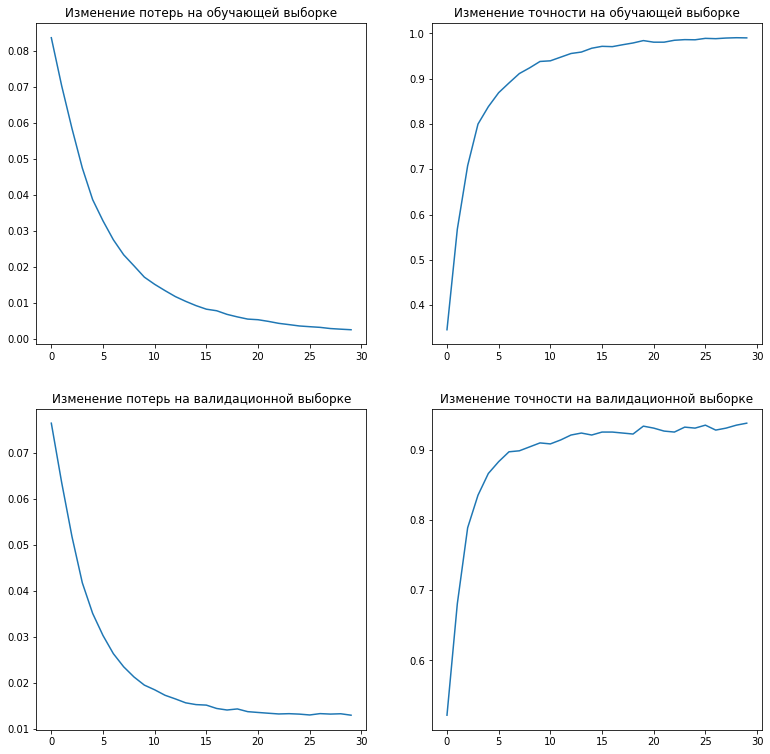

In [221]:
graf(loss, acc)

In [222]:
example_text = tokenizer.decode(bert_input.input_ids[0])
print(example_text)

[CLS] How to become a Travel Blogger [SEP] How to Start a Travelling YouTube channel [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [223]:
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_true_labels = []
    all_preds = []
    for inputs, labels in tqdm(dataloader['test']): 
        mask = inputs['attention_mask'].to(device)
        input_id = inputs['input_ids'].squeeze(1).to(device)
        labels = labels.to(device)
        outputs = model(input_id, mask)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() #* inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_true_labels.extend(labels.tolist())
        all_preds.extend(preds.tolist())
    epoch_loss = running_loss / len(datasets['test'])
    epoch_acc = running_corrects.double() / len(datasets['test'])
    print('{} loss: {:.4f}, acc: {:.4f}'.format('test',
                                                        epoch_loss,
                                                        epoch_acc
                                                ))
            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [224]:
# попробует обучать только последний слой. Обновим модель
model_1 = BertClassifier().to(device)
optimizer_1 = Adam(model_1.parameters(), lr = 1e-3)
for name, param in model_1.named_parameters():
    param.requires_grad = False 
    if name == 'linear.weight' or name == 'linear.bias':
        param.requires_grad = True
        print('ok')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ok
ok


In [225]:
all_true_labels, all_preds, inputs_str, loss, acc = train_model(model_1, criterion, optimizer_1, epox_num)

Epoch 1/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.85it/s]


train loss: 0.0783, acc: 0.4471


100%|██████████| 45/45 [00:02<00:00, 21.50it/s]


val loss: 0.0690, acc: 0.6146
Epoch 2/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.86it/s]


train loss: 0.0676, acc: 0.5420


100%|██████████| 45/45 [00:02<00:00, 21.35it/s]


val loss: 0.0619, acc: 0.5710
Epoch 3/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.77it/s]


train loss: 0.0621, acc: 0.6043


100%|██████████| 45/45 [00:02<00:00, 21.23it/s]


val loss: 0.0556, acc: 0.7060
Epoch 4/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.74it/s]


train loss: 0.0588, acc: 0.6163


100%|██████████| 45/45 [00:02<00:00, 21.30it/s]


val loss: 0.0539, acc: 0.6765
Epoch 5/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.79it/s]


train loss: 0.0558, acc: 0.6479


100%|██████████| 45/45 [00:02<00:00, 20.94it/s]


val loss: 0.0523, acc: 0.6315
Epoch 6/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.87it/s]


train loss: 0.0534, acc: 0.6528


100%|██████████| 45/45 [00:02<00:00, 21.41it/s]


val loss: 0.0481, acc: 0.7370
Epoch 7/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.88it/s]


train loss: 0.0515, acc: 0.6764


100%|██████████| 45/45 [00:02<00:00, 21.30it/s]


val loss: 0.0459, acc: 0.7539
Epoch 8/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.92it/s]


train loss: 0.0513, acc: 0.6789


100%|██████████| 45/45 [00:02<00:00, 21.42it/s]


val loss: 0.0450, acc: 0.7581
Epoch 9/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.94it/s]


train loss: 0.0507, acc: 0.6870


100%|██████████| 45/45 [00:02<00:00, 21.43it/s]


val loss: 0.0442, acc: 0.7482
Epoch 10/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.95it/s]


train loss: 0.0494, acc: 0.6908


100%|██████████| 45/45 [00:02<00:00, 21.35it/s]


val loss: 0.0422, acc: 0.7848
Epoch 11/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.97it/s]


train loss: 0.0498, acc: 0.6838


100%|██████████| 45/45 [00:02<00:00, 21.46it/s]


val loss: 0.0428, acc: 0.7651
Epoch 12/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.97it/s]


train loss: 0.0487, acc: 0.6982


100%|██████████| 45/45 [00:02<00:00, 21.43it/s]


val loss: 0.0409, acc: 0.7890
Epoch 13/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.95it/s]


train loss: 0.0491, acc: 0.6936


100%|██████████| 45/45 [00:02<00:00, 21.35it/s]


val loss: 0.0404, acc: 0.7820
Epoch 14/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.93it/s]


train loss: 0.0482, acc: 0.7056


100%|██████████| 45/45 [00:02<00:00, 21.45it/s]


val loss: 0.0403, acc: 0.7820
Epoch 15/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.96it/s]


train loss: 0.0484, acc: 0.6947


100%|██████████| 45/45 [00:02<00:00, 21.34it/s]


val loss: 0.0414, acc: 0.7581
Epoch 16/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.93it/s]


train loss: 0.0464, acc: 0.7133


100%|██████████| 45/45 [00:02<00:00, 21.44it/s]


val loss: 0.0392, acc: 0.7806
Epoch 17/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.93it/s]


train loss: 0.0472, acc: 0.7017


100%|██████████| 45/45 [00:02<00:00, 21.41it/s]


val loss: 0.0388, acc: 0.7792
Epoch 18/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.98it/s]


train loss: 0.0464, acc: 0.7088


100%|██████████| 45/45 [00:02<00:00, 21.42it/s]


val loss: 0.0393, acc: 0.7764
Epoch 19/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.96it/s]


train loss: 0.0472, acc: 0.7084


100%|██████████| 45/45 [00:02<00:00, 21.31it/s]


val loss: 0.0418, acc: 0.7131
Epoch 20/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.92it/s]


train loss: 0.0460, acc: 0.7161


100%|██████████| 45/45 [00:02<00:00, 21.35it/s]


val loss: 0.0402, acc: 0.7609
Epoch 21/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.90it/s]


train loss: 0.0466, acc: 0.7168


100%|██████████| 45/45 [00:02<00:00, 21.34it/s]


val loss: 0.0367, acc: 0.7792
Epoch 22/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.90it/s]


train loss: 0.0460, acc: 0.7112


100%|██████████| 45/45 [00:02<00:00, 21.36it/s]


val loss: 0.0390, acc: 0.7651
Epoch 23/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.90it/s]


train loss: 0.0452, acc: 0.7242


100%|██████████| 45/45 [00:02<00:00, 21.37it/s]


val loss: 0.0375, acc: 0.7947
Epoch 24/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.90it/s]


train loss: 0.0457, acc: 0.7190


100%|██████████| 45/45 [00:02<00:00, 21.33it/s]


val loss: 0.0408, acc: 0.7145
Epoch 25/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.92it/s]


train loss: 0.0463, acc: 0.7140


100%|██████████| 45/45 [00:02<00:00, 21.44it/s]


val loss: 0.0364, acc: 0.7904
Epoch 26/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.85it/s]


train loss: 0.0452, acc: 0.7256


100%|██████████| 45/45 [00:02<00:00, 21.32it/s]


val loss: 0.0365, acc: 0.7876
Epoch 27/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.91it/s]


train loss: 0.0462, acc: 0.7154


100%|██████████| 45/45 [00:02<00:00, 21.43it/s]


val loss: 0.0411, acc: 0.7778
Epoch 28/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.92it/s]


train loss: 0.0454, acc: 0.7151


100%|██████████| 45/45 [00:02<00:00, 21.48it/s]


val loss: 0.0373, acc: 0.7834
Epoch 29/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.96it/s]


train loss: 0.0446, acc: 0.7263


100%|██████████| 45/45 [00:02<00:00, 21.45it/s]


val loss: 0.0357, acc: 0.8031
Epoch 30/30
----------
start train


100%|██████████| 178/178 [00:08<00:00, 20.93it/s]


train loss: 0.0448, acc: 0.7218


100%|██████████| 45/45 [00:02<00:00, 21.46it/s]

val loss: 0.0414, acc: 0.7173


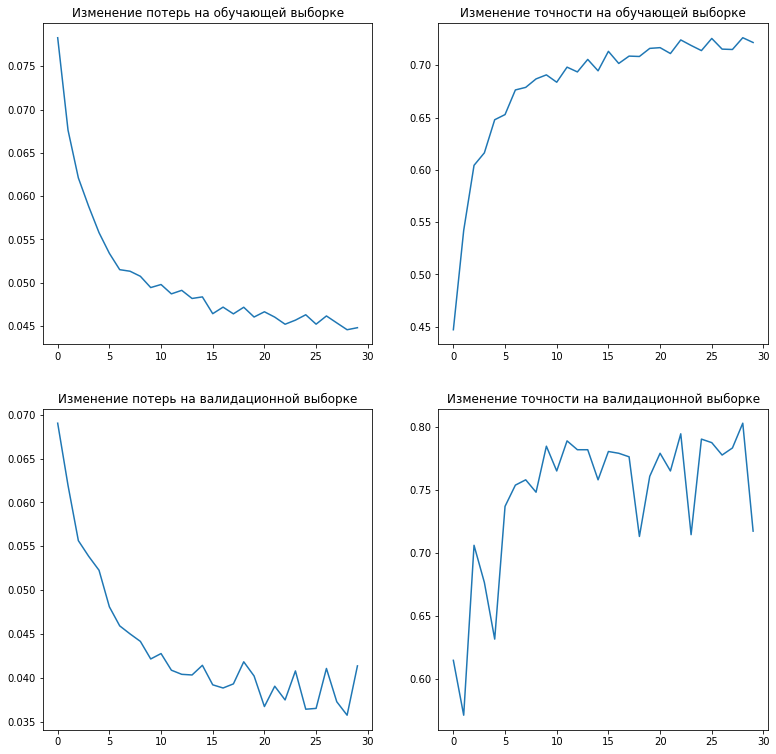

In [226]:
graf(loss, acc)

In [227]:
# обучим только четные слои (мы знаем что делаем)
model_2 = BertClassifier().to(device)
list_train = ['bert.encoder.layer.2', 'bert.encoder.layer.4', 'bert.encoder.layer.6',
             'bert.encoder.layer.8', 'bert.encoder.layer.10', 'linear.weight', 'linear.bias']
optimizer_2 = Adam(model_2.parameters(), lr = 1e-3)
for name, param in model_2.named_parameters():
    param.requires_grad = False 
    for name_layer in list_train:
        if name_layer in name:
            param.requires_grad = True
            print(name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert.encoder.layer.2.attention.self.query.weight
bert.encoder.layer.2.attention.self.query.bias
bert.encoder.layer.2.attention.self.key.weight
bert.encoder.layer.2.attention.self.key.bias
bert.encoder.layer.2.attention.self.value.weight
bert.encoder.layer.2.attention.self.value.bias
bert.encoder.layer.2.attention.output.dense.weight
bert.encoder.layer.2.attention.output.dense.bias
bert.encoder.layer.2.attention.output.LayerNorm.weight
bert.encoder.layer.2.attention.output.LayerNorm.bias
bert.encoder.layer.2.intermediate.dense.weight
bert.encoder.layer.2.intermediate.dense.bias
bert.encoder.layer.2.output.dense.weight
bert.encoder.layer.2.output.dense.bias
bert.encoder.layer.2.output.LayerNorm.weight
bert.encoder.layer.2.output.LayerNorm.bias
bert.encoder.layer.4.attention.self.query.weight
bert.encoder.layer.4.attention.self.query.bias
bert.encoder.layer.4.attention.self.key.weight
bert.encoder.layer.4.attention.self.key.bias
bert.encoder.layer.4.attention.self.value.weight
bert.encode

In [228]:
#проверим работает ли такой подход (много текста поэтому закоменчу)
#for name, param in model_2.named_parameters():
#    print(name , param)

In [229]:
all_true_labels, all_preds, inputs_str, loss, acc = train_model(model_2, criterion, optimizer_2, epox_num)

Epoch 1/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0886, acc: 0.3025


100%|██████████| 45/45 [00:02<00:00, 22.44it/s]


val loss: 0.0874, acc: 0.3038
Epoch 2/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.50it/s]


train loss: 0.0869, acc: 0.2884


100%|██████████| 45/45 [00:02<00:00, 22.30it/s]


val loss: 0.0898, acc: 0.2658
Epoch 3/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.50it/s]


train loss: 0.0879, acc: 0.2835


100%|██████████| 45/45 [00:02<00:00, 22.27it/s]


val loss: 0.0868, acc: 0.3038
Epoch 4/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0867, acc: 0.2898


100%|██████████| 45/45 [00:02<00:00, 22.45it/s]


val loss: 0.0872, acc: 0.2602
Epoch 5/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0861, acc: 0.3025


100%|██████████| 45/45 [00:02<00:00, 22.48it/s]


val loss: 0.0878, acc: 0.2602
Epoch 6/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0864, acc: 0.2895


100%|██████████| 45/45 [00:01<00:00, 22.52it/s]


val loss: 0.0883, acc: 0.3038
Epoch 7/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0863, acc: 0.3000


100%|██████████| 45/45 [00:01<00:00, 22.50it/s]


val loss: 0.0884, acc: 0.3038
Epoch 8/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.53it/s]


train loss: 0.0862, acc: 0.2990


100%|██████████| 45/45 [00:01<00:00, 22.53it/s]


val loss: 0.0882, acc: 0.2602
Epoch 9/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0860, acc: 0.2962


100%|██████████| 45/45 [00:02<00:00, 22.47it/s]


val loss: 0.0879, acc: 0.3038
Epoch 10/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0864, acc: 0.3004


100%|██████████| 45/45 [00:02<00:00, 22.45it/s]


val loss: 0.0871, acc: 0.2602
Epoch 11/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0862, acc: 0.3004


100%|██████████| 45/45 [00:02<00:00, 22.40it/s]


val loss: 0.0890, acc: 0.2658
Epoch 12/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0866, acc: 0.2923


100%|██████████| 45/45 [00:02<00:00, 22.33it/s]


val loss: 0.0873, acc: 0.3038
Epoch 13/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0863, acc: 0.3067


100%|██████████| 45/45 [00:02<00:00, 22.36it/s]


val loss: 0.0871, acc: 0.3038
Epoch 14/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0862, acc: 0.3078


100%|██████████| 45/45 [00:02<00:00, 22.42it/s]


val loss: 0.0879, acc: 0.2602
Epoch 15/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0862, acc: 0.3025


100%|██████████| 45/45 [00:02<00:00, 22.48it/s]


val loss: 0.0870, acc: 0.3038
Epoch 16/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0861, acc: 0.3021


100%|██████████| 45/45 [00:01<00:00, 22.54it/s]


val loss: 0.0879, acc: 0.3038
Epoch 17/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.54it/s]


train loss: 0.0861, acc: 0.2919


100%|██████████| 45/45 [00:02<00:00, 22.47it/s]


val loss: 0.0870, acc: 0.3038
Epoch 18/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.48it/s]


train loss: 0.0862, acc: 0.2986


100%|██████████| 45/45 [00:02<00:00, 22.44it/s]


val loss: 0.0888, acc: 0.3038
Epoch 19/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.50it/s]


train loss: 0.0862, acc: 0.2955


100%|██████████| 45/45 [00:02<00:00, 22.47it/s]


val loss: 0.0872, acc: 0.3038
Epoch 20/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0862, acc: 0.3043


100%|██████████| 45/45 [00:02<00:00, 22.37it/s]


val loss: 0.0874, acc: 0.3038
Epoch 21/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0859, acc: 0.3074


100%|██████████| 45/45 [00:02<00:00, 22.41it/s]


val loss: 0.0874, acc: 0.3038
Epoch 22/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.50it/s]


train loss: 0.0862, acc: 0.2937


100%|██████████| 45/45 [00:02<00:00, 22.35it/s]


val loss: 0.0870, acc: 0.3038
Epoch 23/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.38it/s]


train loss: 0.0860, acc: 0.3018


100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


val loss: 0.0876, acc: 0.3038
Epoch 24/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.50it/s]


train loss: 0.0861, acc: 0.3064


100%|██████████| 45/45 [00:02<00:00, 22.43it/s]


val loss: 0.0872, acc: 0.3038
Epoch 25/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0861, acc: 0.3078


100%|██████████| 45/45 [00:02<00:00, 22.45it/s]


val loss: 0.0870, acc: 0.2602
Epoch 26/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.53it/s]


train loss: 0.0860, acc: 0.2972


100%|██████████| 45/45 [00:02<00:00, 22.48it/s]


val loss: 0.0873, acc: 0.3038
Epoch 27/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0860, acc: 0.3134


100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


val loss: 0.0870, acc: 0.2602
Epoch 28/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.51it/s]


train loss: 0.0863, acc: 0.2976


100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


val loss: 0.0875, acc: 0.2658
Epoch 29/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0863, acc: 0.2839


100%|██████████| 45/45 [00:02<00:00, 22.45it/s]


val loss: 0.0878, acc: 0.3038
Epoch 30/30
----------
start train


100%|██████████| 178/178 [00:18<00:00,  9.52it/s]


train loss: 0.0865, acc: 0.2979


100%|██████████| 45/45 [00:02<00:00, 22.21it/s]

val loss: 0.0897, acc: 0.3038


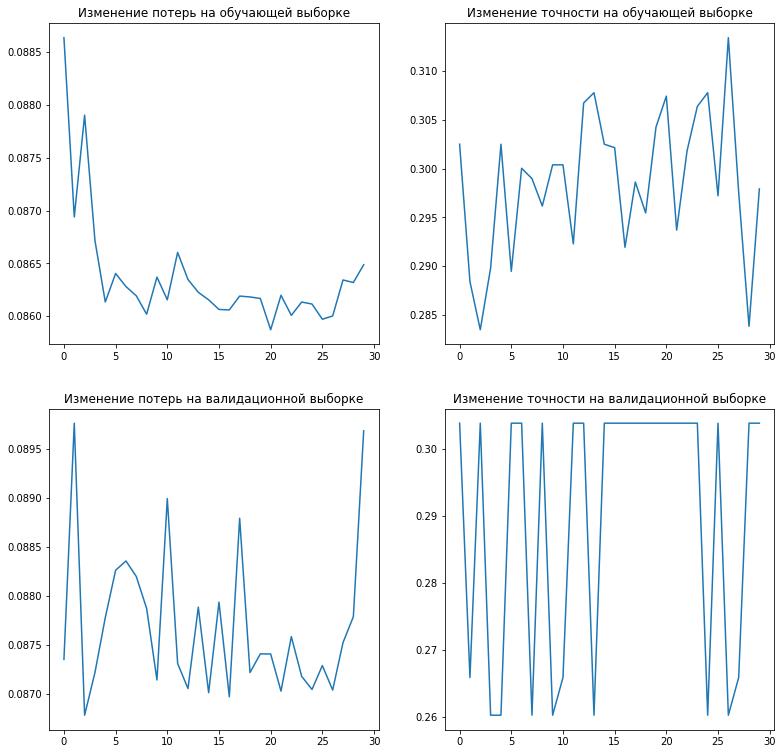

In [230]:
graf(loss, acc)

In [231]:
# обучим только нечетные слои (мы знаем что делаем)
model_3 = BertClassifier().to(device)
list_train = ['bert.encoder.layer.1', 'bert.encoder.layer.3', 'bert.encoder.layer.5',
             'bert.encoder.layer.7', 'bert.encoder.layer.9', 'bert.encoder.layer.11','linear.weight', 'linear.bias']
optimizer_3 = Adam(model_3.parameters(), lr = 1e-3)
for name, param in model_3.named_parameters():
    param.requires_grad = False 
    for name_layer in list_train:
        if name_layer in name:
            param.requires_grad = True

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [232]:
all_true_labels, all_preds, inputs_str, loss, acc = train_model(model_3, criterion, optimizer_3, epox_num)

Epoch 1/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.36it/s]


train loss: 0.0897, acc: 0.2884


100%|██████████| 45/45 [00:02<00:00, 22.33it/s]


val loss: 0.0948, acc: 0.2602
Epoch 2/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.34it/s]


train loss: 0.0894, acc: 0.2881


100%|██████████| 45/45 [00:02<00:00, 22.34it/s]


val loss: 0.0893, acc: 0.2658
Epoch 3/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.35it/s]


train loss: 0.0890, acc: 0.2881


100%|██████████| 45/45 [00:02<00:00, 22.41it/s]


val loss: 0.0922, acc: 0.3038
Epoch 4/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.36it/s]


train loss: 0.0873, acc: 0.2937


100%|██████████| 45/45 [00:02<00:00, 22.43it/s]


val loss: 0.0899, acc: 0.2658
Epoch 5/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0868, acc: 0.2916


100%|██████████| 45/45 [00:02<00:00, 22.45it/s]


val loss: 0.0878, acc: 0.2602
Epoch 6/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0867, acc: 0.2898


100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


val loss: 0.0889, acc: 0.3038
Epoch 7/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0865, acc: 0.3032


100%|██████████| 45/45 [00:02<00:00, 22.44it/s]


val loss: 0.0873, acc: 0.2602
Epoch 8/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0861, acc: 0.2919


100%|██████████| 45/45 [00:02<00:00, 22.37it/s]


val loss: 0.0872, acc: 0.3038
Epoch 9/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.35it/s]


train loss: 0.0857, acc: 0.3043


100%|██████████| 45/45 [00:02<00:00, 22.45it/s]


val loss: 0.0879, acc: 0.2602
Epoch 10/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.35it/s]


train loss: 0.0862, acc: 0.2944


100%|██████████| 45/45 [00:02<00:00, 22.40it/s]


val loss: 0.0895, acc: 0.2602
Epoch 11/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.34it/s]


train loss: 0.0865, acc: 0.2948


100%|██████████| 45/45 [00:02<00:00, 22.44it/s]


val loss: 0.0870, acc: 0.3038
Epoch 12/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0860, acc: 0.2934


100%|██████████| 45/45 [00:02<00:00, 22.37it/s]


val loss: 0.0908, acc: 0.3038
Epoch 13/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0859, acc: 0.3088


100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


val loss: 0.0888, acc: 0.2602
Epoch 14/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.36it/s]


train loss: 0.0856, acc: 0.3039


100%|██████████| 45/45 [00:02<00:00, 22.41it/s]


val loss: 0.0871, acc: 0.3038
Epoch 15/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.36it/s]


train loss: 0.0856, acc: 0.3095


100%|██████████| 45/45 [00:02<00:00, 22.36it/s]


val loss: 0.0871, acc: 0.3038
Epoch 16/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.36it/s]


train loss: 0.0858, acc: 0.3043


100%|██████████| 45/45 [00:02<00:00, 22.38it/s]


val loss: 0.0886, acc: 0.3038
Epoch 17/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.35it/s]


train loss: 0.0857, acc: 0.3088


100%|██████████| 45/45 [00:02<00:00, 22.42it/s]


val loss: 0.0881, acc: 0.3038
Epoch 18/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0858, acc: 0.3011


100%|██████████| 45/45 [00:02<00:00, 22.38it/s]


val loss: 0.0870, acc: 0.3038
Epoch 19/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.34it/s]


train loss: 0.0856, acc: 0.3039


100%|██████████| 45/45 [00:02<00:00, 22.40it/s]


val loss: 0.0873, acc: 0.3038
Epoch 20/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.35it/s]


train loss: 0.0861, acc: 0.2976


100%|██████████| 45/45 [00:02<00:00, 22.43it/s]


val loss: 0.0870, acc: 0.2602
Epoch 21/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0857, acc: 0.2997


100%|██████████| 45/45 [00:02<00:00, 22.44it/s]


val loss: 0.0873, acc: 0.2602
Epoch 22/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.38it/s]


train loss: 0.0858, acc: 0.3014


100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


val loss: 0.0870, acc: 0.3038
Epoch 23/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.38it/s]


train loss: 0.0857, acc: 0.3057


100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


val loss: 0.0875, acc: 0.2602
Epoch 24/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.38it/s]


train loss: 0.0858, acc: 0.3039


100%|██████████| 45/45 [00:02<00:00, 22.45it/s]


val loss: 0.0883, acc: 0.3038
Epoch 25/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0857, acc: 0.3021


100%|██████████| 45/45 [00:02<00:00, 22.17it/s]


val loss: 0.0881, acc: 0.3038
Epoch 26/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.38it/s]


train loss: 0.0856, acc: 0.3057


100%|██████████| 45/45 [00:02<00:00, 22.50it/s]


val loss: 0.0870, acc: 0.3038
Epoch 27/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.33it/s]


train loss: 0.0855, acc: 0.3190


100%|██████████| 45/45 [00:02<00:00, 22.42it/s]


val loss: 0.0892, acc: 0.3038
Epoch 28/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.36it/s]


train loss: 0.0859, acc: 0.3011


100%|██████████| 45/45 [00:02<00:00, 22.48it/s]


val loss: 0.0868, acc: 0.3038
Epoch 29/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.36it/s]


train loss: 0.0858, acc: 0.3039


100%|██████████| 45/45 [00:02<00:00, 22.40it/s]


val loss: 0.0874, acc: 0.3038
Epoch 30/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.37it/s]


train loss: 0.0856, acc: 0.3211


100%|██████████| 45/45 [00:02<00:00, 22.46it/s]

val loss: 0.0874, acc: 0.3038


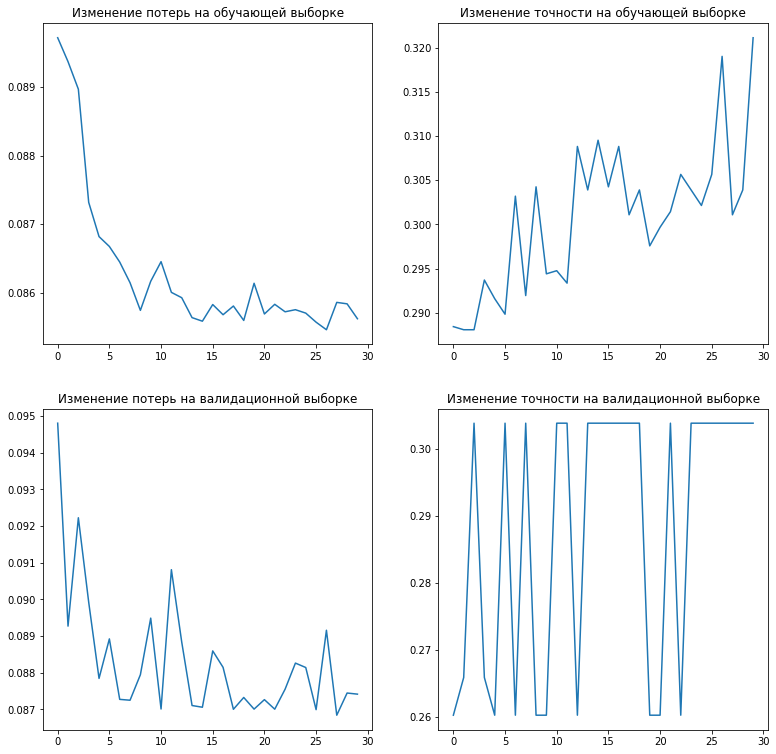

In [233]:
graf(loss, acc)

In [234]:
# обучим только первую половину
model_4 = BertClassifier().to(device)
list_train = ['bert.encoder.layer.1', 'bert.encoder.layer.2', 'bert.encoder.layer.3',
             'bert.encoder.layer.4', 'bert.encoder.layer.5', 'bert.encoder.layer.6','linear.weight', 'linear.bias']
optimizer_4 = Adam(model_4.parameters(), lr = 1e-3)
for name, param in model_4.named_parameters():
    param.requires_grad = False 
    for name_layer in list_train:
        if name_layer in name:
            param.requires_grad = True

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [235]:
all_true_labels, all_preds, inputs_str, loss, acc = train_model(model_4, criterion, optimizer_4, epox_num)

Epoch 1/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.09it/s]


train loss: 0.0885, acc: 0.2919


100%|██████████| 45/45 [00:02<00:00, 22.17it/s]


val loss: 0.0881, acc: 0.2602
Epoch 2/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.08it/s]


train loss: 0.0865, acc: 0.2923


100%|██████████| 45/45 [00:01<00:00, 22.63it/s]


val loss: 0.0885, acc: 0.3038
Epoch 3/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.08it/s]


train loss: 0.0867, acc: 0.2958


100%|██████████| 45/45 [00:01<00:00, 22.64it/s]


val loss: 0.0873, acc: 0.2658
Epoch 4/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0865, acc: 0.2923


100%|██████████| 45/45 [00:01<00:00, 22.71it/s]


val loss: 0.0874, acc: 0.2658
Epoch 5/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.11it/s]


train loss: 0.0864, acc: 0.3025


100%|██████████| 45/45 [00:01<00:00, 22.75it/s]


val loss: 0.0870, acc: 0.3038
Epoch 6/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0857, acc: 0.3018


100%|██████████| 45/45 [00:01<00:00, 22.75it/s]


val loss: 0.0876, acc: 0.2602
Epoch 7/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0857, acc: 0.2990


100%|██████████| 45/45 [00:01<00:00, 22.72it/s]


val loss: 0.0875, acc: 0.3038
Epoch 8/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.09it/s]


train loss: 0.0860, acc: 0.2979


100%|██████████| 45/45 [00:01<00:00, 22.70it/s]


val loss: 0.0872, acc: 0.3038
Epoch 9/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.07it/s]


train loss: 0.0856, acc: 0.3085


100%|██████████| 45/45 [00:01<00:00, 22.70it/s]


val loss: 0.0874, acc: 0.3038
Epoch 10/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.09it/s]


train loss: 0.0857, acc: 0.3116


100%|██████████| 45/45 [00:01<00:00, 22.62it/s]


val loss: 0.0876, acc: 0.3038
Epoch 11/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.09it/s]


train loss: 0.0856, acc: 0.3000


100%|██████████| 45/45 [00:01<00:00, 22.66it/s]


val loss: 0.0886, acc: 0.3038
Epoch 12/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.09it/s]


train loss: 0.0855, acc: 0.3113


100%|██████████| 45/45 [00:01<00:00, 22.59it/s]


val loss: 0.0887, acc: 0.2602
Epoch 13/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.08it/s]


train loss: 0.0855, acc: 0.3085


100%|██████████| 45/45 [00:01<00:00, 22.72it/s]


val loss: 0.0871, acc: 0.3038
Epoch 14/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.08it/s]


train loss: 0.0856, acc: 0.3099


100%|██████████| 45/45 [00:01<00:00, 22.65it/s]


val loss: 0.0869, acc: 0.3038
Epoch 15/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.09it/s]


train loss: 0.0855, acc: 0.3032


100%|██████████| 45/45 [00:01<00:00, 22.71it/s]


val loss: 0.0877, acc: 0.3038
Epoch 16/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0855, acc: 0.3046


100%|██████████| 45/45 [00:01<00:00, 22.62it/s]


val loss: 0.0870, acc: 0.3038
Epoch 17/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0854, acc: 0.3155


100%|██████████| 45/45 [00:01<00:00, 22.72it/s]


val loss: 0.0880, acc: 0.3038
Epoch 18/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.08it/s]


train loss: 0.0854, acc: 0.3085


100%|██████████| 45/45 [00:01<00:00, 22.74it/s]


val loss: 0.0873, acc: 0.3038
Epoch 19/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0854, acc: 0.3148


100%|██████████| 45/45 [00:01<00:00, 22.72it/s]


val loss: 0.0871, acc: 0.3038
Epoch 20/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.09it/s]


train loss: 0.0855, acc: 0.3028


100%|██████████| 45/45 [00:01<00:00, 22.69it/s]


val loss: 0.0874, acc: 0.3038
Epoch 21/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.09it/s]


train loss: 0.0855, acc: 0.3208


100%|██████████| 45/45 [00:01<00:00, 22.63it/s]


val loss: 0.0872, acc: 0.3038
Epoch 22/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.09it/s]


train loss: 0.0856, acc: 0.3120


100%|██████████| 45/45 [00:01<00:00, 22.74it/s]


val loss: 0.0880, acc: 0.3038
Epoch 23/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.09it/s]


train loss: 0.0855, acc: 0.3046


100%|██████████| 45/45 [00:01<00:00, 22.75it/s]


val loss: 0.0870, acc: 0.3038
Epoch 24/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0855, acc: 0.3099


100%|██████████| 45/45 [00:01<00:00, 22.72it/s]


val loss: 0.0870, acc: 0.3038
Epoch 25/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0854, acc: 0.3081


100%|██████████| 45/45 [00:01<00:00, 22.68it/s]


val loss: 0.0877, acc: 0.2602
Epoch 26/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.09it/s]


train loss: 0.0853, acc: 0.3095


100%|██████████| 45/45 [00:01<00:00, 22.63it/s]


val loss: 0.0875, acc: 0.3038
Epoch 27/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.07it/s]


train loss: 0.0854, acc: 0.3102


100%|██████████| 45/45 [00:01<00:00, 22.70it/s]


val loss: 0.0873, acc: 0.2658
Epoch 28/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.08it/s]


train loss: 0.0853, acc: 0.3183


100%|██████████| 45/45 [00:01<00:00, 22.74it/s]


val loss: 0.0877, acc: 0.3038
Epoch 29/30
----------
start train


100%|██████████| 178/178 [00:21<00:00,  8.10it/s]


train loss: 0.0851, acc: 0.3211


100%|██████████| 45/45 [00:01<00:00, 22.74it/s]


val loss: 0.0877, acc: 0.2658
Epoch 30/30
----------
start train


100%|██████████| 178/178 [00:22<00:00,  8.08it/s]


train loss: 0.0855, acc: 0.3102


100%|██████████| 45/45 [00:01<00:00, 22.70it/s]

val loss: 0.0871, acc: 0.3038


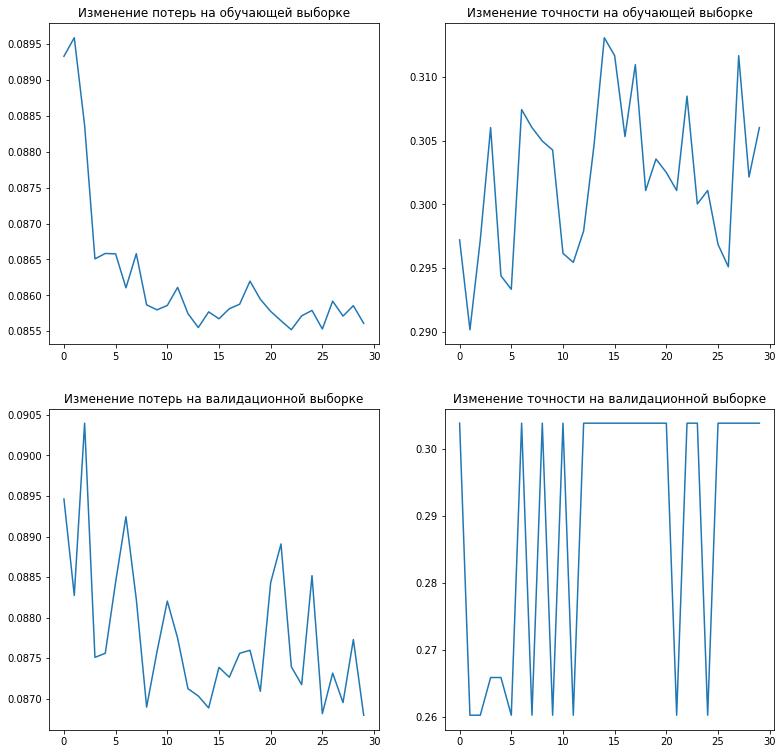

In [240]:
graf(loss, acc)

In [236]:
# обучим только вторую половину
model_5 = BertClassifier().to(device)
list_train = ['bert.encoder.layer.7', 'bert.encoder.layer.8', 'bert.encoder.layer.9',
             'bert.encoder.layer.10', 'bert.encoder.layer.11', 'linear.weight', 'linear.bias']
optimizer_5 = Adam(model_5.parameters(), lr = 1e-3)
for name, param in model_5.named_parameters():
    param.requires_grad = False 
    for name_layer in list_train:
        if name_layer in name:
            param.requires_grad = True

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [237]:
all_true_labels, all_preds, inputs_str, loss, acc = train_model(model_5, criterion, optimizer_5, epox_num)

Epoch 1/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.33it/s]


train loss: 0.0893, acc: 0.2972


100%|██████████| 45/45 [00:02<00:00, 21.48it/s]


val loss: 0.0895, acc: 0.3038
Epoch 2/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.34it/s]


train loss: 0.0896, acc: 0.2902


100%|██████████| 45/45 [00:02<00:00, 21.46it/s]


val loss: 0.0883, acc: 0.2602
Epoch 3/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.32it/s]


train loss: 0.0884, acc: 0.2972


100%|██████████| 45/45 [00:02<00:00, 21.47it/s]


val loss: 0.0904, acc: 0.2602
Epoch 4/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.31it/s]


train loss: 0.0865, acc: 0.3060


100%|██████████| 45/45 [00:02<00:00, 21.77it/s]


val loss: 0.0875, acc: 0.2658
Epoch 5/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.33it/s]


train loss: 0.0866, acc: 0.2944


100%|██████████| 45/45 [00:02<00:00, 21.73it/s]


val loss: 0.0876, acc: 0.2658
Epoch 6/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.32it/s]


train loss: 0.0866, acc: 0.2934


100%|██████████| 45/45 [00:02<00:00, 21.88it/s]


val loss: 0.0884, acc: 0.2602
Epoch 7/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.32it/s]


train loss: 0.0861, acc: 0.3074


100%|██████████| 45/45 [00:02<00:00, 21.82it/s]


val loss: 0.0892, acc: 0.3038
Epoch 8/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.30it/s]


train loss: 0.0866, acc: 0.3060


100%|██████████| 45/45 [00:02<00:00, 21.84it/s]


val loss: 0.0882, acc: 0.2602
Epoch 9/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.33it/s]


train loss: 0.0859, acc: 0.3050


100%|██████████| 45/45 [00:02<00:00, 21.75it/s]


val loss: 0.0869, acc: 0.3038
Epoch 10/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.34it/s]


train loss: 0.0858, acc: 0.3043


100%|██████████| 45/45 [00:02<00:00, 21.94it/s]


val loss: 0.0876, acc: 0.2602
Epoch 11/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.34it/s]


train loss: 0.0859, acc: 0.2962


100%|██████████| 45/45 [00:02<00:00, 21.86it/s]


val loss: 0.0882, acc: 0.3038
Epoch 12/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.34it/s]


train loss: 0.0861, acc: 0.2955


100%|██████████| 45/45 [00:02<00:00, 21.79it/s]


val loss: 0.0877, acc: 0.2602
Epoch 13/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.33it/s]


train loss: 0.0857, acc: 0.2979


100%|██████████| 45/45 [00:02<00:00, 21.83it/s]


val loss: 0.0871, acc: 0.3038
Epoch 14/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.34it/s]


train loss: 0.0856, acc: 0.3046


100%|██████████| 45/45 [00:02<00:00, 21.83it/s]


val loss: 0.0870, acc: 0.3038
Epoch 15/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.33it/s]


train loss: 0.0858, acc: 0.3130


100%|██████████| 45/45 [00:02<00:00, 21.84it/s]


val loss: 0.0869, acc: 0.3038
Epoch 16/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.35it/s]


train loss: 0.0857, acc: 0.3116


100%|██████████| 45/45 [00:02<00:00, 21.63it/s]


val loss: 0.0874, acc: 0.3038
Epoch 17/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.33it/s]


train loss: 0.0858, acc: 0.3053


100%|██████████| 45/45 [00:02<00:00, 21.82it/s]


val loss: 0.0873, acc: 0.3038
Epoch 18/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.35it/s]


train loss: 0.0859, acc: 0.3109


100%|██████████| 45/45 [00:02<00:00, 21.44it/s]


val loss: 0.0876, acc: 0.3038
Epoch 19/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.34it/s]


train loss: 0.0862, acc: 0.3011


100%|██████████| 45/45 [00:02<00:00, 21.85it/s]


val loss: 0.0876, acc: 0.3038
Epoch 20/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.33it/s]


train loss: 0.0859, acc: 0.3036


100%|██████████| 45/45 [00:02<00:00, 21.88it/s]


val loss: 0.0871, acc: 0.3038
Epoch 21/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.33it/s]


train loss: 0.0858, acc: 0.3025


100%|██████████| 45/45 [00:02<00:00, 21.84it/s]


val loss: 0.0884, acc: 0.3038
Epoch 22/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.32it/s]


train loss: 0.0856, acc: 0.3011


100%|██████████| 45/45 [00:02<00:00, 21.85it/s]


val loss: 0.0889, acc: 0.2602
Epoch 23/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.34it/s]


train loss: 0.0855, acc: 0.3085


100%|██████████| 45/45 [00:02<00:00, 21.89it/s]


val loss: 0.0874, acc: 0.3038
Epoch 24/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.34it/s]


train loss: 0.0857, acc: 0.3000


100%|██████████| 45/45 [00:02<00:00, 21.82it/s]


val loss: 0.0872, acc: 0.3038
Epoch 25/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.36it/s]


train loss: 0.0858, acc: 0.3011


100%|██████████| 45/45 [00:02<00:00, 21.86it/s]


val loss: 0.0885, acc: 0.2602
Epoch 26/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.32it/s]


train loss: 0.0855, acc: 0.2969


100%|██████████| 45/45 [00:02<00:00, 21.63it/s]


val loss: 0.0868, acc: 0.3038
Epoch 27/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.31it/s]


train loss: 0.0859, acc: 0.2951


100%|██████████| 45/45 [00:02<00:00, 21.76it/s]


val loss: 0.0873, acc: 0.3038
Epoch 28/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.31it/s]


train loss: 0.0857, acc: 0.3116


100%|██████████| 45/45 [00:02<00:00, 21.72it/s]


val loss: 0.0870, acc: 0.3038
Epoch 29/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.31it/s]


train loss: 0.0859, acc: 0.3021


100%|██████████| 45/45 [00:02<00:00, 21.70it/s]


val loss: 0.0877, acc: 0.3038
Epoch 30/30
----------
start train


100%|██████████| 178/178 [00:15<00:00, 11.31it/s]


train loss: 0.0856, acc: 0.3060


100%|██████████| 45/45 [00:02<00:00, 21.76it/s]

val loss: 0.0868, acc: 0.3038


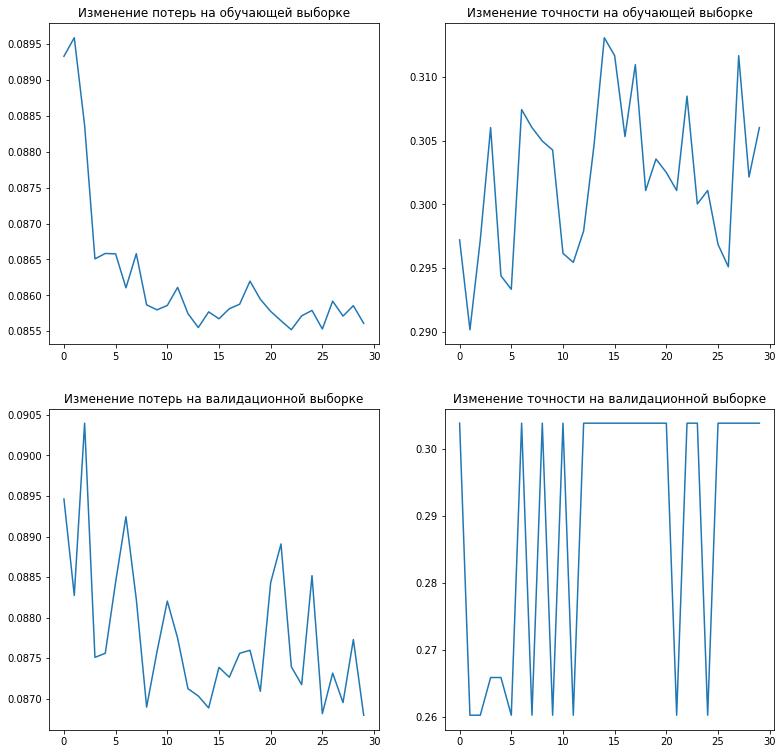

In [238]:
graf(loss, acc)

In [239]:
model_1.layer()

AttributeError: 'BertClassifier' object has no attribute 'layer'

In [ ]:

model_1.features[15].parameters()

In [ ]:
model_1.parameters()